This solution is built on the following notebooks. 

Reference: 
1. https://www.kaggle.com/code/mayer79/m5-forecast-poisson-loss-top-10
2. https://www.kaggle.com/code/anshuls235/time-series-forecasting-eda-fe-modelling

# Import packages

In [1]:
import pandas as pd
import numpy as np
import os

import models
import utils

%load_ext autoreload
%autoreload 2

# Notebook settings

In [2]:
debug = False   # Use subsample data if debug=True

# Load data

In [3]:
data_dir = "data"
submission_dir = "submissions"
os.makedirs(submission_dir, exist_ok=True)

calendar = pd.read_csv(os.path.join(data_dir, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(data_dir, "sell_prices.csv"))
sample_submission_accuracy = pd.read_csv(os.path.join(data_dir, "sample_submission_accuracy.csv"))
sample_submission_uncertainty = pd.read_csv(os.path.join(data_dir, "sample_submission_uncertainty.csv"))
sales = pd.read_csv(os.path.join(data_dir, "sales_train_evaluation.csv"))

In [4]:
sample_submission_accuracy['id']

0        HOBBIES_1_001_CA_1_validation
1        HOBBIES_1_002_CA_1_validation
2        HOBBIES_1_003_CA_1_validation
3        HOBBIES_1_004_CA_1_validation
4        HOBBIES_1_005_CA_1_validation
                     ...              
60975      FOODS_3_823_WI_3_evaluation
60976      FOODS_3_824_WI_3_evaluation
60977      FOODS_3_825_WI_3_evaluation
60978      FOODS_3_826_WI_3_evaluation
60979      FOODS_3_827_WI_3_evaluation
Name: id, Length: 60980, dtype: object

In [5]:
sample_submission_uncertainty[(sample_submission_uncertainty['id'].str.startswith('HOBBIES_1_001_CA_1'))]['id']

12350     HOBBIES_1_001_CA_1_0.005_validation
55190     HOBBIES_1_001_CA_1_0.025_validation
98030     HOBBIES_1_001_CA_1_0.165_validation
140870    HOBBIES_1_001_CA_1_0.250_validation
183710    HOBBIES_1_001_CA_1_0.500_validation
226550    HOBBIES_1_001_CA_1_0.750_validation
269390    HOBBIES_1_001_CA_1_0.835_validation
312230    HOBBIES_1_001_CA_1_0.975_validation
355070    HOBBIES_1_001_CA_1_0.995_validation
397910    HOBBIES_1_001_CA_1_0.005_evaluation
440750    HOBBIES_1_001_CA_1_0.025_evaluation
483590    HOBBIES_1_001_CA_1_0.165_evaluation
526430    HOBBIES_1_001_CA_1_0.250_evaluation
569270    HOBBIES_1_001_CA_1_0.500_evaluation
612110    HOBBIES_1_001_CA_1_0.750_evaluation
654950    HOBBIES_1_001_CA_1_0.835_evaluation
697790    HOBBIES_1_001_CA_1_0.975_evaluation
740630    HOBBIES_1_001_CA_1_0.995_evaluation
Name: id, dtype: object

In [6]:
# Quantiles required by M5 uncertainty
q_levels = [0.005, 0.025, 0.165, 0.25, 0.5, 0.750, 0.835, 0.975, 0.995]

## Prepare data

In [7]:
calendar = utils.prep_calendar(calendar)
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,11101,1,1,2011,1,1,1,0,0,0
1,11101,2,1,2011,2,1,1,0,0,0
2,11101,3,1,2011,3,1,1,0,0,0
3,11101,4,2,2011,4,1,1,1,1,0
4,11101,5,2,2011,5,1,1,1,0,1


In [8]:
x_train, x_valid, y_train, y_valid, test, features = utils.prepare_training_data(sales, calendar, selling_prices, drop_d=1000-28)

In [9]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape, test.shape

((25053633, 20), (2783737, 20), (25053633,), (2783737,), (3414880, 23))

In [10]:
x_valid

,state_id,dept_id,rolling_mean_lag7_w7,rolling_mean_lag7_w28,event_name_1,cat_id,item_id,wday,snap_TX,lag_t28,store_id,event_name_2,lag_t7,rolling_mean_lag28_w28,year,sell_price,month,rolling_mean_lag28_w7,snap_WI,snap_CA
11504520,1,6,0.000000,0.142857,1,3,2081,6,0,0.0,4,1,0.0,0.142857,2014,7.98,12,0.142857,0,1
24160035,1,3,0.285714,0.428571,1,1,1197,1,0,0.0,4,1,0.0,0.642857,2016,1.00,1,0.142857,0,0
25700385,3,4,0.142857,0.214286,1,2,1802,2,1,0.0,10,1,0.0,0.214286,2016,14.72,3,0.285714,0,0
7027236,2,3,0.000000,0.000000,1,1,729,6,0,0.0,5,1,0.0,0.000000,2014,1.18,7,0.000000,0,1
6939249,2,3,0.714286,0.607143,1,1,1163,3,1,0.0,6,1,2.0,0.428571,2014,2.98,7,0.142857,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20598905,2,3,0.285714,0.357143,1,1,1299,3,0,0.0,6,1,0.0,0.071429,2015,3.57,9,0.285714,0,0
27382803,1,3,0.857143,0.857143,17,1,1172,2,0,1.0,1,1,0.0,0.928571,2016,3.00,5,0.857143,1,1
8391450,1,6,2.857143,3.535714,1,3,2040,2,0,9.0,3,1,0.0,3.821429,2014,2.97,8,3.285714,0,0
21405768,1,1,0.428571,0.750000,1,1,177,2,0,0.0,1,1,1.0,0.821429,2015,9.97,10,1.285714,0,0


In [11]:
y_valid

11504520    1.0
24160035    1.0
25700385    0.0
7027236     0.0
6939249     1.0
           ... 
20598905    0.0
27382803    1.0
8391450     1.0
21405768    0.0
19874504    0.0
Name: demand, Length: 2783737, dtype: float32

In [12]:
test

,id,item_id,store_id,state_id,dept_id,cat_id,d,demand,lag_t7,rolling_mean_lag7_w7,...,rolling_mean_lag28_w28,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price
25276210,HOBBIES_1_001_CA_1,1438,1,1,4,2,1858,0.0,4.0,1.142857,...,0.785714,3,2,2016,1,1,0,0,0,8.26
25276211,HOBBIES_1_002_CA_1,1439,1,1,4,2,1858,0.0,0.0,0.285714,...,0.178571,3,2,2016,1,1,0,0,0,3.97
25276212,HOBBIES_1_003_CA_1,1440,1,1,4,2,1858,0.0,0.0,0.428571,...,0.107143,3,2,2016,1,1,0,0,0,2.97
25276213,HOBBIES_1_004_CA_1,1441,1,1,4,2,1858,0.0,2.0,1.857143,...,2.071429,3,2,2016,1,1,0,0,0,4.64
25276214,HOBBIES_1_005_CA_1,1442,1,1,4,2,1858,1.0,0.0,0.857143,...,0.750000,3,2,2016,1,1,0,0,0,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28691085,FOODS_3_823_WI_3,1433,10,3,3,1,1969,NaN,NaN,NaN,...,0.642857,2,6,2016,18,4,0,0,0,2.98
28691086,FOODS_3_824_WI_3,1434,10,3,3,1,1969,NaN,NaN,NaN,...,0.285714,2,6,2016,18,4,0,0,0,2.48
28691087,FOODS_3_825_WI_3,1435,10,3,3,1,1969,NaN,NaN,NaN,...,0.785714,2,6,2016,18,4,0,0,0,3.98
28691088,FOODS_3_826_WI_3,1436,10,3,3,1,1969,NaN,NaN,NaN,...,1.321429,2,6,2016,18,4,0,0,0,1.28


In [13]:
if debug:
    x_train, y_train = x_train[:100000], y_train[:100000]
    x_valid, y_valid = x_valid[:10000], y_valid[:10000]

# Training and Evaluation

## Mean prediction

[LightGBM] [Info] Total Bins 1782
[LightGBM] [Info] Number of data points in the train set: 25053633, number of used features: 20
[LightGBM] [Info] Start training from score 0.206062
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.28052
[200]	valid_0's rmse: 2.25028
[300]	valid_0's rmse: 2.22219
[400]	valid_0's rmse: 2.20411
[500]	valid_0's rmse: 2.19355
[600]	valid_0's rmse: 2.18382
[700]	valid_0's rmse: 2.17798
[800]	valid_0's rmse: 2.17201
[900]	valid_0's rmse: 2.24342
[1000]	valid_0's rmse: 2.16379
[1100]	valid_0's rmse: 2.15988
[1200]	valid_0's rmse: 2.15506
[1300]	valid_0's rmse: 2.15154
[1400]	valid_0's rmse: 2.14845
[1500]	valid_0's rmse: 2.14598
[1600]	valid_0's rmse: 2.14276
[1700]	valid_0's rmse: 2.14006
[1800]	valid_0's rmse: 2.1378
[1900]	valid_0's rmse: 2.13532
[2000]	valid_0's rmse: 2.13398
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 2.13398


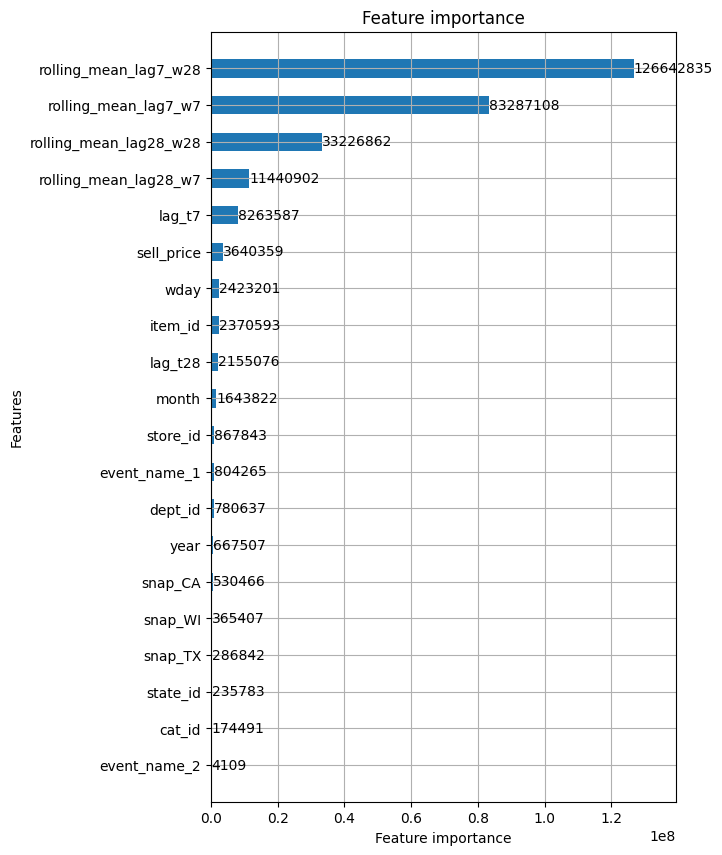

In [14]:
lgbm = models.LGBM().fit(x_train, x_valid, y_train, y_valid)

In [15]:
pred = utils.forecast_point_horizon(lgbm, test, features)

/Users/tim/Documents/HKUST/math5470/m5_forecasting/utils.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.99277158 0.24183682 0.62167024 ... 0.71823947 0.97867053 0.91275092]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  pred.loc[pred.d==day, "demand"] = model.predict(test_day[features])


In [16]:
pd.concat([test[test['d'] >= utils.FIRST]['demand'], pred[pred['d'] >= utils.FIRST]['demand']], axis=1)

,demand,demand
27837370,NaN,0.992772
27837371,NaN,0.241837
27837372,NaN,0.621670
27837373,NaN,1.566538
27837374,NaN,1.334516
...,...,...
28691085,NaN,0.595974
28691086,NaN,0.324310
28691087,NaN,0.752737
28691088,NaN,1.269550


In [17]:
utils.save_accuracy_submission(
    pred, 
    cols_template=sample_submission_accuracy, 
    filepath=os.path.join(submission_dir, "submission_accuracy.csv")
)

True

In [18]:
submission_accuracy = pd.read_csv(os.path.join(submission_dir, "submission_accuracy.csv"))

submission_accuracy

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.912007,0.849327,0.842805,0.868373,0.921375,1.062071,1.000661,0.888854,0.729695,...,0.911303,1.011304,1.000919,0.777887,0.724954,0.758819,0.737474,0.847364,0.989499,0.904332
1,FOODS_1_001_CA_1_validation,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,6.000000,...,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,FOODS_1_001_CA_2_evaluation,0.776977,0.763847,0.758056,0.719579,0.838674,1.141040,0.978038,0.860481,0.754229,...,1.005763,1.239991,1.076290,0.824538,0.754621,0.786346,0.697554,0.822258,1.073453,0.959055
3,FOODS_1_001_CA_2_validation,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000
4,FOODS_1_001_CA_3_evaluation,0.798634,0.770010,0.785362,0.788562,0.905263,1.068254,1.120171,1.050153,0.943009,...,1.024456,1.192548,1.046561,0.885403,0.843463,0.888587,0.845506,0.927918,1.076204,1.066260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,HOUSEHOLD_2_516_WI_1_validation,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
60976,HOUSEHOLD_2_516_WI_2_evaluation,0.099211,0.097854,0.098830,0.096513,0.113187,0.122527,0.107723,0.093437,0.086246,...,0.121101,0.132568,0.123867,0.120103,0.115478,0.118726,0.111194,0.130159,0.147541,0.106694
60977,HOUSEHOLD_2_516_WI_2_validation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60978,HOUSEHOLD_2_516_WI_3_evaluation,0.096262,0.092869,0.092035,0.094294,0.097547,0.104716,0.098485,0.089395,0.080222,...,0.104627,0.116256,0.110824,0.087057,0.093786,0.094779,0.092924,0.112332,0.119450,0.099394


## Uncertainty (quantile) prediction

In [19]:
# Train distributional LightGBM model (Negative Binomial) and inspect quantiles
dist_lgbm = models.DistributionalLGBM().fit(x_train, x_valid, y_train, y_valid)

[LightGBM] [Info] Total Bins 1782
[LightGBM] [Info] Number of data points in the train set: 25053633, number of used features: 20
[LightGBM] [Info] Start training from score 0.206062
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.28052
[200]	valid_0's rmse: 2.25028
[300]	valid_0's rmse: 2.22219
[400]	valid_0's rmse: 2.20411
[500]	valid_0's rmse: 2.19355
[600]	valid_0's rmse: 2.18382
[700]	valid_0's rmse: 2.17798
[800]	valid_0's rmse: 2.17201
[900]	valid_0's rmse: 2.24342
[1000]	valid_0's rmse: 2.16379
[1100]	valid_0's rmse: 2.15988
[1200]	valid_0's rmse: 2.15506
[1300]	valid_0's rmse: 2.15154
[1400]	valid_0's rmse: 2.14845
[1500]	valid_0's rmse: 2.14598
[1600]	valid_0's rmse: 2.14276
[1700]	valid_0's rmse: 2.14006
[1800]	valid_0's rmse: 2.1378
[1900]	valid_0's rmse: 2.13532
[2000]	valid_0's rmse: 2.13398
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 2.13398


In [20]:
# Recursive quantile forecasts
pred_per_q_dist_lgbm = utils.forecast_quantile_horizon(dist_lgbm, test, features, q_levels)

In [21]:
# Convert to submission file format
utils.save_uncertainty_submission(
    pred_per_q_dist_lgbm,
    cols_template=sample_submission_uncertainty,
    filepath=os.path.join(submission_dir, "submission_uncertainty_dist_lgbm.csv")
)

True

In [22]:
submission_uncertainty_dist_lgbm = pd.read_csv(os.path.join(submission_dir, "submission_uncertainty_dist_lgbm.csv"))

submission_uncertainty_dist_lgbm

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_0.005_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FOODS_1_001_CA_1_0.005_validation,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,...,2.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,FOODS_1_001_CA_1_0.025_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FOODS_1_001_CA_1_0.025_validation,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,...,2.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,FOODS_1_001_CA_1_0.165_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548815,HOUSEHOLD_2_516_WI_3_0.835_validation,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
548816,HOUSEHOLD_2_516_WI_3_0.975_evaluation,23.0,24.0,24.0,23.0,23.0,21.0,22.0,2.0,2.0,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
548817,HOUSEHOLD_2_516_WI_3_0.975_validation,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
548818,HOUSEHOLD_2_516_WI_3_0.995_evaluation,34.0,36.0,36.0,35.0,34.0,32.0,34.0,3.0,2.0,...,2.0,2.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,3.0


In [23]:
# Train NGBoost Poisson model and inspect predictive quantiles
ngb = models.NGBoostPoisson().fit(x_train, x_valid, y_train, y_valid)

[iter 0] loss=2.4020 val_loss=2.3357 scale=0.1250 norm=0.1637


In [24]:
# Recursive quantile forecasts
pred_per_q_ngb = utils.forecast_quantile_horizon(ngb, test, features, q_levels)

In [25]:
# Convert to submission file format
utils.save_uncertainty_submission(
    pred_per_q_ngb,
    cols_template=sample_submission_uncertainty,
    filepath=os.path.join(submission_dir, "submission_uncertainty_ngb.csv")
)

True

In [26]:
submission_uncertainty_ngb = pd.read_csv(os.path.join(submission_dir, "submission_uncertainty_ngb.csv"))

submission_uncertainty_ngb

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_0.005_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FOODS_1_001_CA_1_0.005_validation,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,...,2.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,FOODS_1_001_CA_1_0.025_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FOODS_1_001_CA_1_0.025_validation,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,...,2.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,FOODS_1_001_CA_1_0.165_evaluation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548815,HOUSEHOLD_2_516_WI_3_0.835_validation,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
548816,HOUSEHOLD_2_516_WI_3_0.975_evaluation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,4.0
548817,HOUSEHOLD_2_516_WI_3_0.975_validation,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
548818,HOUSEHOLD_2_516_WI_3_0.995_evaluation,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,7.0,7.0
